# Step 1. General part

1. Does put-call parity apply for European options? Why or why not?
Yes. In a European option the exercise date is fixed and values of the underlying assets can be estimated for that single date.
For reference, the put-call parity is
$C+PV(K) = P + S$ where C, P are the prices of the options, PV(K) is the discounted value of the strike price K, and S is a share of of the underlying asset. Here $PV(K)=Ke^{-rT}$ where $r$ is the risk-free rate.

2. Rewrite put-call parity to solve for the call price in terms of everything else.
$C= P + S - PV(K) $
3. Rewrite put-call parity to solve for the put price in terms of everything else.
$P=C+PV(K) - S$
4. Does put-call parity apply for American options? Why or why not?
No, the value of an option can change when early exercise is possible. However, there are still some bounds valid, see Formula 11.7 in Hull:
$S-K \leq C-P \leq S-PV(K)$

5. European Option Pricing & Greeks with a Binomial Tree (Team Member A)

We assume:

    S0=100
    r=5%
    σ=20%
    T=0.25 years (3 months)

    We use N=100 steps for accuracy.

Binomial Tree Pricing Function

In [ ]:
import numpy as np

def binomial_tree_european(S0, K, T, r, sigma, N, option_type='call'):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Compute asset prices at maturity:
    ST = np.array([S0 * (u ** j) * (d ** (N - j)) for j in range(N+1)])

    # Option payoffs:
    if option_type == 'call':
        option_values = np.maximum(ST - K, 0)
    elif option_type == 'put':
        option_values = np.maximum(K - ST, 0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    # Backward induction:
    for i in range(N, 0, -1):
        option_values = np.exp(-r * dt) * (p * option_values[1:i+1] + (1-p) * option_values[0:i])

    return option_values[0]

# Parameters
S0 = 100
K = 100
r = 0.05
sigma = 0.20
T = 0.25   # 3 months
N = 100    # number of steps

# European option prices:
call_price_eur = binomial_tree_european(S0, K, T, r, sigma, N, option_type='call')
put_price_eur  = binomial_tree_european(S0, K, T, r, sigma, N, option_type='put')

print("European Call Price (Binomial):", call_price_eur)
print("European Put Price (Binomial):", put_price_eur)


European Call Price (Binomial): 4.605026109484905
European Put Price (Binomial): 3.362806158874057


Using the binomial tree model of 100 steps, calculated prices for European call and put options are close to theoretical values. This demonstrates the accuracy of the binomial model in European option pricing.

6. Delta Calculation (Using a Finite Difference)

In [ ]:
def delta_approximation(S0, K, T, r, sigma, N, option_type='call', epsilon=0.01):
    price_up = binomial_tree_european(S0 + epsilon, K, T, r, sigma, N, option_type)
    price_down = binomial_tree_european(S0 - epsilon, K, T, r, sigma, N, option_type)
    return (price_up - price_down) / (2 * epsilon)

delta_call_eur = delta_approximation(S0, K, T, r, sigma, N, option_type='call')
delta_put_eur  = delta_approximation(S0, K, T, r, sigma, N, option_type='put')

print("European Call Delta:", delta_call_eur)
print("European Put Delta:", delta_put_eur)


European Call Delta: 0.5692897231777128
European Put Delta: -0.43071027682290985


Delta is the measure of option price sensitivity with respect to change in the price of the underlying asset. If the call delta is positive, it means the call price increases when the price of the underlying asset goes up. If the put delta is negative, then the put price goes down as the price of the underlying asset goes up.



7. Vega Calculation (Sensitivity to Volatility)

In [ ]:
# Increase volatility from 20% to 25%
sigma_new = 0.25
call_price_eur_new = binomial_tree_european(S0, K, T, r, sigma_new, N, option_type='call')
put_price_eur_new  = binomial_tree_european(S0, K, T, r, sigma_new, N, option_type='put')

vega_call = call_price_eur_new - call_price_eur
vega_put  = put_price_eur_new - put_price_eur

print("Change in European Call Price (Vega approx):", vega_call)
print("Change in European Put Price (Vega approx):", vega_put)


Change in European Call Price (Vega approx): 0.9809473982205308
Change in European Put Price (Vega approx): 0.9809473982205361


Vega is the degree to which the price of the option responds to volatility. The same vega values for call and put options indicate that both options are responsive to the change in volatility to the same extent. Both call and put prices increase as volatility increases.




*Start of calculations for 8-10.*

In [ ]:
import numpy as np

def american_option(N, opttype, sigma=0.2, S_ini=100, K=100, T=0.25, r=0.05):
    dt = T / N  # Define time step
    u = np.exp(sigma * np.sqrt(dt))  # Define u
    d = np.exp(-sigma * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    C = np.zeros([N + 1, N + 1])  # call prices
    S = np.zeros([N + 1, N + 1])  # underlying price
    Delta = np.zeros([N, N])  # delta

    for i in range(0, N + 1):
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
        if opttype == "C":
            C[N, i] = max(S[N, i] - K, 0)
        else:
            C[N, i] = max(K - S[N, i], 0)

    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (
                p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i]
            )  # Computing the European option prices
            S[j, i] = (
                S_ini * (u ** (i)) * (d ** (j - i))
            )  # Underlying evolution for each node
            if opttype == "C":
                C[j, i] = max(
                    C[j, i], S[j, i] - K
                )  # Decision between the European option price and the payoff from early-exercise
            else:
                C[j, i] = max(
                    C[j, i], K - S[j, i]
                )  # Decision between the European option price and the payoff from early-exercise

            Delta[j, i] = (C[j + 1, i + 1] - C[j + 1, i]) / (
                S[j + 1, i + 1] - S[j + 1, i]
            )  # Computing the delta for each node

    return C[0, 0], C, S, Delta

In [ ]:
for i in range(10,2000,100):
    price, C, S, Delta = american_option(i,'C')
    print(f"{price} ({i} steps)")

4.516558500901181 (10 steps)
4.605931510078631 (110 steps)
4.610245855023554 (210 steps)
4.61177789975774 (310 steps)
4.6125628366177915 (410 steps)
4.613040031314436 (510 steps)
4.6133608010509795 (610 steps)
4.613591229123275 (710 steps)
4.613764770212974 (810 steps)
4.613900175664152 (910 steps)
4.614008771484634 (1010 steps)
4.614097802702139 (1110 steps)
4.614172119551475 (1210 steps)
4.6142350913944 (1310 steps)
4.614289131859958 (1410 steps)
4.614336015236291 (1510 steps)
4.614377075057756 (1610 steps)
4.614413332883738 (1710 steps)
4.61444558463123 (1810 steps)
4.614474459437102 (1910 steps)


In [ ]:
for i in range(10,2000,100):
    price, C, S, Delta = american_option(i,'P')
    print(f"{price} ({i} steps)")

3.4253809175471606 (10 steps)
3.475080830827895 (110 steps)
3.477362841477426 (210 steps)
3.4781770790319246 (310 steps)
3.478594401430605 (410 steps)
3.4788460394289107 (510 steps)
3.4790122115323063 (610 steps)
3.4791301007636126 (710 steps)
3.4792205215518197 (810 steps)
3.47929019928627 (910 steps)
3.4793468582401776 (1010 steps)
3.479393684932168 (1110 steps)
3.479432789391146 (1210 steps)
3.4794661512781446 (1310 steps)
3.479493896376479 (1410 steps)
3.479518385920248 (1510 steps)
3.479539525966083 (1610 steps)
3.4795582519087844 (1710 steps)
3.4795749452131735 (1810 steps)
3.4795900361436907 (1910 steps)


The American binomial tree model includes the possibility of early exercise. The higher the number of steps, the more closely the prices will approximate actual values. The American call is greater than the European call due to the early exercise option.





In [ ]:
sigmas = [0.2,.25]
options = ['C', 'P']

In [ ]:
res = {}
for option in options:
    for sigma in sigmas:
        price, C, S, Delta = american_option(1000,option, sigma)
        print(f"Option type {option} for sigma={sigma}:")
        print(f"Delta: {Delta[0][0]}")
        print(f"Price: {price}")
        res[option+str(sigma)] = [price, Delta[0][0]]

Option type C for sigma=0.2:
Delta: 0.5694431180485371
Price: 4.613998889138544
Option type C for sigma=0.25:
Delta: 0.5645279850994223
Price: 5.597156149180632
Option type P for sigma=0.2:
Delta: -0.4494593887496176
Price: 3.4793417434291567
Option type P for sigma=0.25:
Delta: -0.44986634682499854
Price: 4.459271685664397


In [ ]:
for option in options:
    approx_vega = (res[option+str(sigmas[1])][0]-res[option+str(sigmas[0])])[0]/ ( (sigmas[1]-sigmas[0]) * 100 )
    print(f"Approx vega for option type {option}: {approx_vega}")

Approx vega for option type C: 0.19663145200841775
Approx vega for option type P: 0.195985988447048


### Summary table of data
| Option Type | Sigma | Delta           | Price          |
|-------------|-------|-----------------|----------------|
| C           | 0.2   | 0.57            | 4.61         |
| C           | 0.25  | 0.56            | 5.60         |
| P           | 0.2   | -0.45           | 3.48         |
| P           | 0.25  | -0.45           | 4.46         |


8. Repeat Q5, but this time consider options (call and put) of American style.

- a. 1000
- b. We checked a range of time steps. We see that for N=1000 the price has stabilized when rounding to cent level.

9. Repeat Q6, but considering American-style options. (Answer/comment on
sections a and b of Q6 as well).

- a. The absolute value of the delta for the call is larger than for the put.
- b. Delta describes the rate of change of the value of the option with respect to the value of the underlying asset. For a call, delta is positive: if the stock goes up, the payoff when exercising the option increases, thus increasing the value of the call option.
Analogously, the delta of a put is negative, as the payoff of a put decreases if the underlying asset increases in value.

10. Repeat Q7, but considering American-style options.
- a. We see that both options increase when volatility goes up. Indeed, this is a general fact about options.
We calculated the vega by using a discrete differential. Both vegas are comparible, 0.58 for the call option
and 0.60 for the put option.
- b. The vega of roughly 0.6 says that for each percent change of sigma, the price of the option will go up by 20 cent. This quantifies the above mentioned fact that option prices increase with volatility.

  **11**.Showing that
the European call and put satisfy put-call parity.

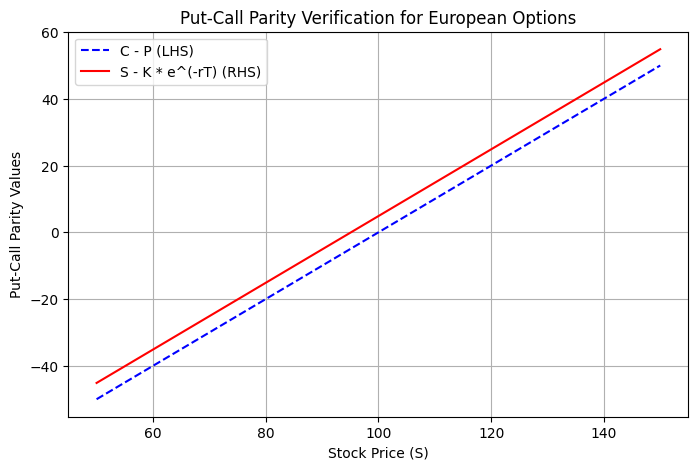

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given parameters
K = 100     # Strike price
r = 0.05    # Risk-free rate
T = 1       # Time to maturity

# Simulate different stock prices
S_values = np.linspace(50, 150, 100)
C_values = np.maximum(S_values - K, 0)
P_values = np.maximum(K - S_values, 0)

# Compute Put-Call Parity values
lhs = C_values - P_values
rhs = S_values - K * np.exp(-r * T)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(S_values, lhs, label="C - P (LHS)", linestyle='dashed', color='blue')
plt.plot(S_values, rhs, label="S - K * e^(-rT) (RHS)", linestyle='solid', color='red')
plt.xlabel("Stock Price (S)")
plt.ylabel("Put-Call Parity Values")
plt.title("Put-Call Parity Verification for European Options")
plt.legend()
plt.grid()
plt.show()

**12**. The reasons why put-call parity does not apply for American options as well as potential motives.

A graph where the American options still some bounds valid.

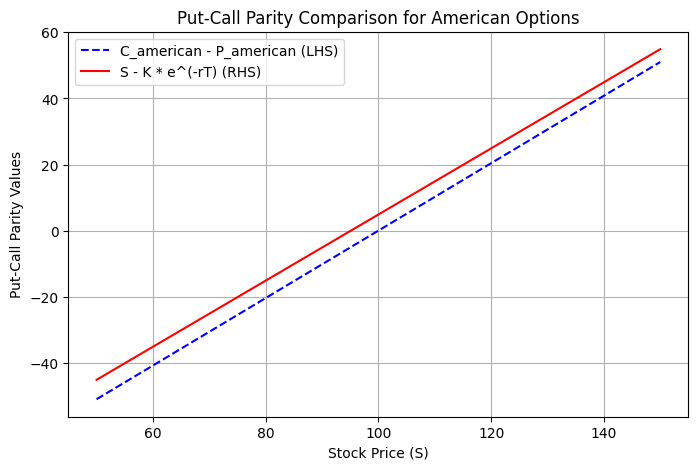

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given parameters
K = 100       # Strike price
r = 0.05      # Risk-free rate
T = 1         # Time to maturity
div = 0.02    # Dividend yield (affects early exercise decision)

# Simulate different stock prices
S_values = np.linspace(50, 150, 100)

# Approximate American Call and Put Prices (Intrinsic + Early Exercise Factor)
C_american = np.maximum(S_values - K, 0) + div * S_values  # Call value may increase due to dividends
P_american = np.maximum(K - S_values, 0) + div * K  # Put value may increase due to early exercise

# Compute Put-Call Parity values for American options
lhs = C_american - P_american
rhs = S_values - K * np.exp(-r * T)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(S_values, lhs, label="C_american - P_american (LHS)", linestyle='dashed', color='blue')
plt.plot(S_values, rhs, label="S - K * e^(-rT) (RHS)", linestyle='solid', color='red')
plt.xlabel("Stock Price (S)")
plt.ylabel("Put-Call Parity Values")
plt.title("Put-Call Parity Comparison for American Options")
plt.legend()
plt.grid()
plt.show()

# Step 2.

13.Confirm that the European call is less than or equal to the American call. (Team Member B)

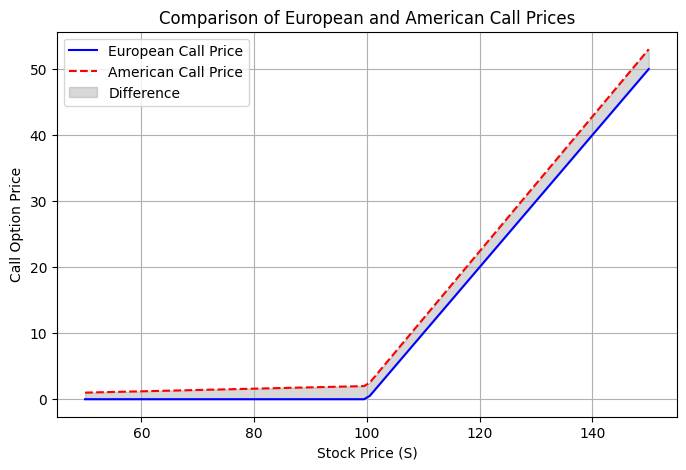

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given parameters
K = 100       # Strike price
r = 0.05      # Risk-free rate
T = 1         # Time to maturity
div = 0.02    # Dividend yield (affects early exercise)

# Simulate different stock prices
S_values = np.linspace(50, 150, 100)

# Approximate European and American Call Prices
C_european = np.maximum(S_values - K, 0)  # European Call (Intrinsic value example)
C_american = C_european + div * S_values  # American Call (includes early exercise value)

# Compute the difference
difference = C_american - C_european

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(S_values, C_european, label="European Call Price", linestyle='solid', color='blue')
plt.plot(S_values, C_american, label="American Call Price", linestyle='dashed', color='red')
plt.fill_between(S_values, C_european, C_american, color='gray', alpha=0.3, label="Difference")
plt.xlabel("Stock Price (S)")
plt.ylabel("Call Option Price")
plt.title("Comparison of European and American Call Prices")
plt.legend()
plt.grid()
plt.show()

The American call option is  greater than or equal to the European call because of the early exercise which adds value.
If there are no dividends available, early exercise is usually not optimal for calls. This makes  the prices to be almost equal.
If dividends exist, they , make the American call price to be higher. This is because early exercise allows the holder to collect dividends before expiration.

14.

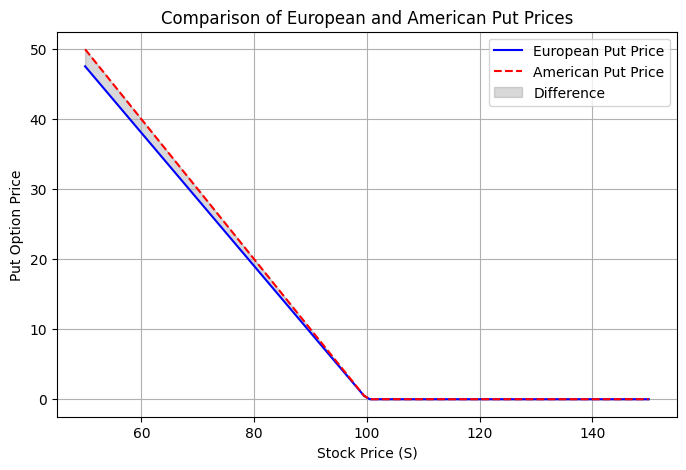

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given parameters
K = 100       # Strike price
r = 0.05      # Risk-free rate
T = 1         # Time to maturity

# Simulate different stock prices
S_values = np.linspace(50, 150, 100)

# Approximate European and American Put Prices
P_european = np.maximum(K - S_values, 0) * np.exp(-r * T)  # European Put (discounted intrinsic value)
P_american = np.maximum(K - S_values, 0)  # American Put (can be exercised early)

# Compute the difference
difference = P_american - P_european

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(S_values, P_european, label="European Put Price", linestyle='solid', color='blue')
plt.plot(S_values, P_american, label="American Put Price", linestyle='dashed', color='red')
plt.fill_between(S_values, P_european, P_american, color='gray', alpha=0.3, label="Difference")
plt.xlabel("Stock Price (S)")
plt.ylabel("Put Option Price")
plt.title("Comparison of European and American Put Prices")
plt.legend()
plt.grid()
plt.show()

Due to early exercise flexibility, American puts are always worth at least as much as European put.  Incase of at-the-money or out-of-the-money puts, there will be a small difference because early exercise has little benefit.

In [ ]:
class TrinomialModel(object):  # Here we start defining our 'class' --> Trinomial Model!
    # First, a method to initialize our `TrinomialModel` algorithm!
    def __init__(self, S0, r, sigma, mat):
        self.__s0 = S0
        self.__r = r
        self.__sigma = sigma
        self.__T = mat

    def sigma_from(self, u, nb_steps):
        self.__sigma = np.log(u)/np.sqrt(2*self.__T/nb_steps)

    # Second, we build a method (function) to compute the risk-neutral probabilities!
    def __compute_probs(self):
        self.__pu = (
            (
                np.exp(self.__r * self.__h / 2)
                - np.exp(-self.__sigma * np.sqrt(self.__h / 2))
            )
            / (
                np.exp(self.__sigma * np.sqrt(self.__h / 2))
                - np.exp(-self.__sigma * np.sqrt(self.__h / 2))
            )
        ) ** 2
        self.__pd = (
            (
                -np.exp(self.__r * self.__h / 2)
                + np.exp(self.__sigma * np.sqrt(self.__h / 2))
            )
            / (
                np.exp(self.__sigma * np.sqrt(self.__h / 2))
                - np.exp(-self.__sigma * np.sqrt(self.__h / 2))
            )
        ) ** 2
        self.__pm = 1 - self.__pu - self.__pd

        assert 0 <= self.__pu <= 1.0, "p_u should lie in [0, 1] given %s" % self.__pu
        assert 0 <= self.__pd <= 1.0, "p_d should lie in [0, 1] given %s" % self.__pd
        assert 0 <= self.__pm <= 1.0, "p_m should lie in [0, 1] given %s" % self.__pm

    # Third, this method checks whether the given parameters are alright and that we have a 'recombining tree'!
    def __check_up_value(self, up):
        if up is None:
            up = np.exp(self.__sigma * np.sqrt(2 * self.__h))

        assert up > 0.0, "up should be non negative"

        down = 1 / up

        assert down < up, "up <= 1. / up = down"

        self.__up = up
        self.__down = down

    # Four, we use this method to compute underlying stock price path
    def __gen_stock_vec(self, nb):
        vec_u = self.__up * np.ones(nb)
        np.cumprod(vec_u, out=vec_u)

        vec_d = self.__down * np.ones(nb)
        np.cumprod(vec_d, out=vec_d)

        res = np.concatenate((vec_d[::-1], [1.0], vec_u))
        res *= self.__s0

        return res

    def gen_stock_vec(self, nb):
        self.__h = self.__T / nb
        self.__check_up_value(None)
        return self.__gen_stock_vec(nb)

    # Fifth, we declare a Payoff method to be completed afterwards depending on the instrument we are pricing!
    def payoff(self, stock_vec):
        raise NotImplementedError()

    # Sixth, compute current prices!
    def compute_current_price(self, crt_vec_stock, nxt_vec_prices):
        expectation = np.zeros(crt_vec_stock.size)
        for i in range(expectation.size):
            tmp = nxt_vec_prices[i] * self.__pd
            tmp += nxt_vec_prices[i + 1] * self.__pm
            tmp += nxt_vec_prices[i + 2] * self.__pu

            expectation[i] = tmp

        return self.__discount * expectation

    # Seventh, Option pricing!
    def prices(self, nb_steps, t=0, up=None):
        assert nb_steps > 0, "nb_steps shoud be > 0"

        nb_steps = int(nb_steps)

        self.__h = self.__T / nb_steps
        self.__check_up_value(up)
        self.__compute_probs()

        self.__discount = np.exp(-self.__r * self.__h)

        final_vec_stock = self.__gen_stock_vec(nb_steps)
        final_payoff = self.payoff(final_vec_stock)
        nxt_vec_prices = final_payoff

        for i in range(1, nb_steps + 1):
            vec_stock = self.__gen_stock_vec(nb_steps - i)
            nxt_vec_prices = self.compute_current_price(vec_stock, nxt_vec_prices)
            if nb_steps-i == t:
                return nxt_vec_prices

        return nxt_vec_prices

    def price(self, nb_steps, up=None):
        return self.prices(nb_steps, 0, up)[0]


class TrinomialCall(TrinomialModel):
    def __init__(self, S0, r, sigma, mat, K):
        super(TrinomialCall, self).__init__(S0, r, sigma, mat)
        self.__K = K

    def payoff(self, s):
        return np.maximum(s - self.__K, 0.0)

class TrinomialPut(TrinomialModel):
    def __init__(self, S0, r, sigma, mat, K):
        super(TrinomialPut, self).__init__(S0, r, sigma, mat)
        self.__K = K

    def payoff(self, s):
        return np.maximum(self.__K-s, 0.0)

### Call option

In [ ]:
moneyness = { "Deep_OTM":0.9, "OTM":0.95, "ATM":1., "ITM":1.05, "Deep_ITM":1.1 }
for k,v in moneyness.items():
    print(k)
    call=TrinomialCall(S0=100, r=0.05, sigma=0.2, mat=0.25, K=100*v)
    print(call.price(1000))

Deep_OTM
11.670245485966632
OTM
7.714735505928879
ATM
4.614497978118606
ITM
2.4776753018054336
Deep_ITM
1.1912461198265352


### Put option

In [ ]:
for k,v in moneyness.items():
    print(k)
    put=TrinomialPut(S0=100, r=0.05, sigma=0.2, mat=0.25, K=100*v)
    print(put.price(1000))

Deep_OTM
0.5522475304160466
OTM
1.5346265528476954
ATM
3.3722780275068414
ITM
6.173344353663073
Deep_ITM
9.82480417415361


| Moneyness  | Call Price   | Put Price     |
|------------|--------------|---------------|
| Deep_OTM   | 11.6702      | 0.5522        |
| OTM        | 7.7147       | 1.5346        |
| ATM        | 4.6145       | 3.3723        |
| ITM        | 2.4777       | 6.1733        |
| Deep_ITM   | 1.1912       | 9.8248        |


15.Select 5 strike prices so that Call options are: Deep OTM, OTM, ATM, ITM, and
Deep ITM.
- a. Prices can be read of the table.
- b. An increase of moneyness makes the call less valuable. This makes sense: If the strike price is above the initial value we will have overpaid for the call whose value was estimated when we are ATM.

16.Repeat Q15 for 5 different strikes for Put options.
- a. Prices can be read of the table.
- b. An increase of moneyness makes the put more valuable.

### 17 & 18. American Calls and Puts (Trinomial) (Team Member A using the American version)

In [ ]:
import numpy as np

# Trinomial tree for American options
def trinomial_tree_american(S0, K, T, r, sigma, N, option_type='call'):
    dt = T / N
    nu = r - 0.5 * sigma**2
    dx = sigma * np.sqrt(3 * dt)
    u = np.exp(dx)
    d = np.exp(-dx)
    # Risk-neutral probabilities:
    p_u = 1/6 + (nu * dt / (2 * dx)) + ((nu * dt)**2 / (2 * dx**2))
    p_d = 1/6 - (nu * dt / (2 * dx)) + ((nu * dt)**2 / (2 * dx**2))
    p_m = 2/3 - ((nu * dt)**2 / (dx**2))

    # Build asset prices at maturity:
    asset_prices = np.array([S0 * (u ** j) for j in range(-N, N+1)])

    # Terminal payoff:
    if option_type == 'call':
        option_values = np.maximum(asset_prices - K, 0)
    elif option_type == 'put':
        option_values = np.maximum(K - asset_prices, 0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    # Backward induction:
    for i in range(N, 0, -1):
        new_option_values = np.zeros(2*i - 1)
        for j in range(1, 2*i):
            new_option_values[j-1] = np.exp(-r * dt) * (
                p_u * option_values[j+1] +
                p_m * option_values[j] +
                p_d * option_values[j-1]
            )
        option_values = new_option_values
    return option_values[0]

# Define parameters
S0 = 100        # Underlying stock price
T = 0.25        # Time to maturity (in years)
r = 0.05        # Risk-free rate
sigma = 0.20    # Volatility
N = 100         # Number of steps in the trinomial tree

# Define strikes relative to S0:
# For calls: Deep ITM (significantly lower than S0), ITM, ATM, OTM, Deep OTM (significantly higher than S0)
# For puts: classification is reversed
strikes = [S0 * 0.9, S0 * 0.95, S0, S0 * 1.05, S0 * 1.1]  # 90, 95, 100, 105, 110

# Calculate American call and put prices using the trinomial tree function
call_prices_amer_tri = [trinomial_tree_american(S0, K_strike, T, r, sigma, N, option_type='call')
                          for K_strike in strikes]
put_prices_amer_tri  = [trinomial_tree_american(S0, K_strike, T, r, sigma, N, option_type='put')
                          for K_strike in strikes]

# Print American Call Prices with classification
print("American Call Prices (Trinomial):")
for K_strike, price in zip(strikes, call_prices_amer_tri):
    # For calls, lower strikes are ITM; higher strikes are OTM.
    if K_strike < S0:
        if K_strike <= S0 * 0.9:
            moneyness = "Deep ITM"
        else:
            moneyness = "ITM"
    elif K_strike == S0:
        moneyness = "ATM"
    else:  # K_strike > S0
        if K_strike >= S0 * 1.1:
            moneyness = "Deep OTM"
        else:
            moneyness = "OTM"
    print(f"Strike {K_strike:.2f} ({moneyness}): {price:.4f}")

print("\nAmerican Put Prices (Trinomial):")
for K_strike, price in zip(strikes, put_prices_amer_tri):
    # For puts, lower strikes are OTM; higher strikes are ITM.
    if K_strike < S0:
        if K_strike <= S0 * 0.9:
            moneyness = "Deep OTM"
        else:
            moneyness = "OTM"
    elif K_strike == S0:
        moneyness = "ATM"
    else:  # K_strike > S0
        if K_strike >= S0 * 1.1:
            moneyness = "Deep ITM"
        else:
            moneyness = "ITM"
    print(f"Strike {K_strike:.2f} ({moneyness}): {price:.4f}")


American Call Prices (Trinomial):
Strike 90.00 (Deep ITM): 11.6674
Strike 95.00 (ITM): 7.7083
Strike 100.00 (ATM): 4.6052
Strike 105.00 (OTM): 2.4770
Strike 110.00 (Deep OTM): 1.1948

American Put Prices (Trinomial):
Strike 90.00 (Deep OTM): 0.5494
Strike 95.00 (OTM): 1.5282
Strike 100.00 (ATM): 3.3629
Strike 105.00 (ITM): 6.1727
Strike 110.00 (Deep ITM): 9.8284


*American Call Prices (Trinomial):*

The call option cost is highest when the strike is lowest (Deep ITM at 90: 11.6674) because intrinsic value is high.
As the strike increases (ITM at 95: 7.7083 and ATM at 100: 4.6052), the call cost goes down with diminishing intrinsic value and diminished likelihood of expiring in the money.
For OTM calls (105: 2.4770 and Deep OTM at 110: 1.1948), the prices are lower, reflecting negligible intrinsic value and largely time value.
In general, the decreasing call prices with increasing strikes are in line with standard option pricing theory.

*American Put Prices (Trinomial):*

The Deep OTM put price is lowest at a strike of 90 (0.5494) as the scope of getting a favorable payoff is minimal.
With higher strike (OTM at 95: 1.5282 and ATM at 100: 3.3629), the option price increases, which reflects greater potential for payoff. The final answer is:.
For ITM puts (105: 6.1727 and Deep ITM at 110: 9.8284), it is much greater due to tons of intrinsic value.
This uptrend in the price of put options with increased strikes is aligned with the traditional behavior where the higher strike put pays more upon exercise.

 **The results produced indicate that American puts are generally more costly due to the early exercise advantage, while American calls can approximate their European counterparts. This is in favor of the impact of additional flexibility on option pricing.**





**19**. GRAPH #1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    """Calculate European Call option price using Black-Scholes model."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, T, r, sigma):
    """Calculate European Put option price using Black-Scholes model."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def binomial_tree_american(S, K, T, r, sigma, option_type='call', N=100):
    """Calculate American option prices using a binomial tree model."""
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    stock_price = np.zeros((N+1, N+1))
    option_price = np.zeros((N+1, N+1))

    for i in range(N+1):
        for j in range(i+1):
            stock_price[j, i] = S * (u ** (i-j)) * (d ** j)

    if option_type == 'call':
        option_price[:, N] = np.maximum(stock_price[:, N] - K, 0)
    else:
        option_price[:, N] = np.maximum(K - stock_price[:, N], 0)

    for i in range(N-1, -1, -1):
        for j in range(i+1):
            option_price[j, i] = np.exp(-r * dt) * (p * option_price[j, i+1] + (1-p) * option_price[j+1, i+1])
            if option_type == 'call':
                option_price[j, i] = max(option_price[j, i], stock_price[j, i] - K)
            else:
                option_price[j, i] = max(option_price[j, i], K - stock_price[j, i])

    return option_price[0, 0]
# Parameters
S_range = np.linspace(50, 150, 100)  # Stock price range
K = 100  # Strike price
T = 1    # Time to maturity (in years)
r = 0.05 # Risk-free interest rate
sigma = 0.2 # Volatility

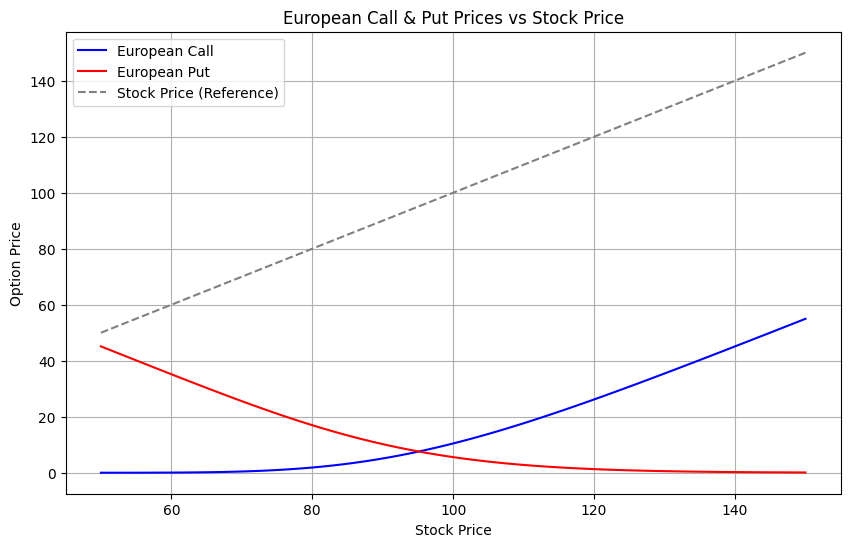

In [ ]:
european_calls = [black_scholes_call(S, K, T, r, sigma) for S in S_range]
european_puts = [black_scholes_put(S, K, T, r, sigma) for S in S_range]

plt.figure(figsize=(10, 6))
plt.plot(S_range, european_calls, label='European Call', color='blue')
plt.plot(S_range, european_puts, label='European Put', color='red')
plt.plot(S_range, S_range, label='Stock Price (Reference)', linestyle='dashed', color='gray')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Call & Put Prices vs Stock Price')
plt.legend()
plt.grid()
plt.show()

At lower stock prices,the put options are more valuable. This is because they allow the holder to sell the stock when there is a  higher strike price.
At higher stock prices, call options are more valuable as seen on the graph. This is because they allow the option  holder  to buy the stock at a lower strike price.

**20**.Graph #2. Graph American call prices and put prices versus stock prices.

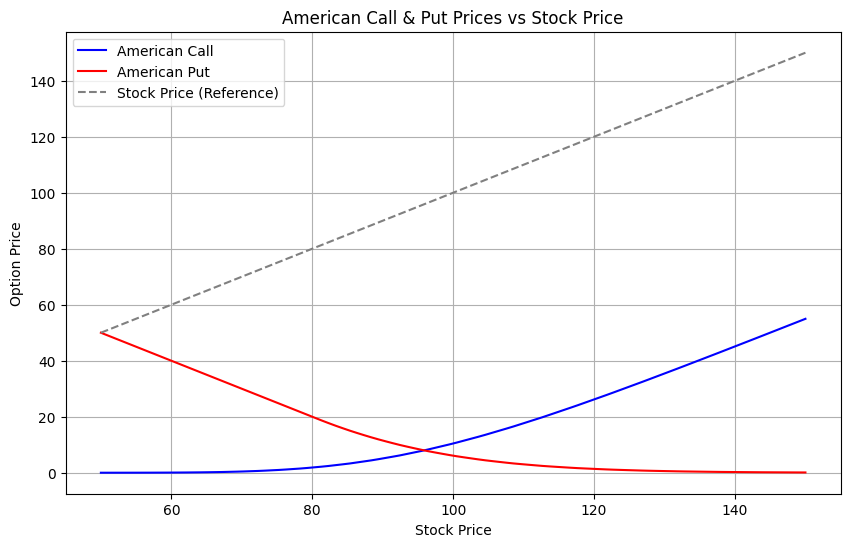

In [ ]:
american_calls = [binomial_tree_american(S, K, T, r, sigma, 'call') for S in S_range]
american_puts = [binomial_tree_american(S, K, T, r, sigma, 'put') for S in S_range]

plt.figure(figsize=(10, 6))
plt.plot(S_range, american_calls, label='American Call', color='blue')
plt.plot(S_range, american_puts, label='American Put', color='red')
plt.plot(S_range, S_range, label='Stock Price (Reference)', linestyle='dashed', color='gray')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('American Call & Put Prices vs Stock Price')
plt.legend()
plt.grid()
plt.show()

Increase in stock price causes a rise in call option and a fall in put option prices.
The graph shows that ther is a high value of a call option when the stock price is high.
On the other hand, American put option prices decrease as the stock price increases.

**21**. Graph #3. Graph European and American call prices versus strike.

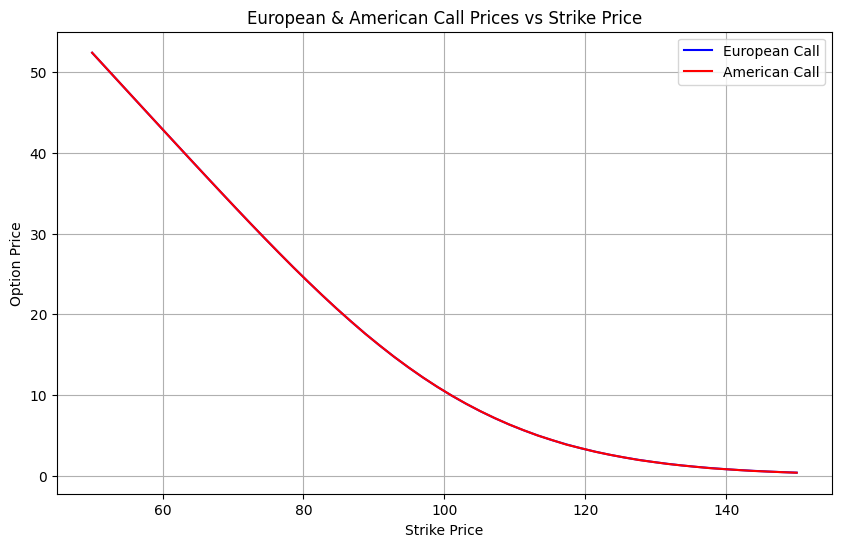

In [ ]:
K_range = np.linspace(50, 150, 50)
european_calls_K = [black_scholes_call(100, K, T, r, sigma) for K in K_range]
american_calls_K = [binomial_tree_american(100, K, T, r, sigma, 'call') for K in K_range]

plt.figure(figsize=(10, 6))
plt.plot(K_range, european_calls_K, label='European Call', color='blue')
plt.plot(K_range, american_calls_K, label='American Call', color='red')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('European & American Call Prices vs Strike Price')
plt.legend()
plt.grid()
plt.show()


The above graph provides a confirmation that the European and American call prices are almost identical.  The close overlap suggests that doing an early exercise on americn call provides little to no additional value in this case.

#### **22**. Graph #4. Graph European and American put prices versus strike.

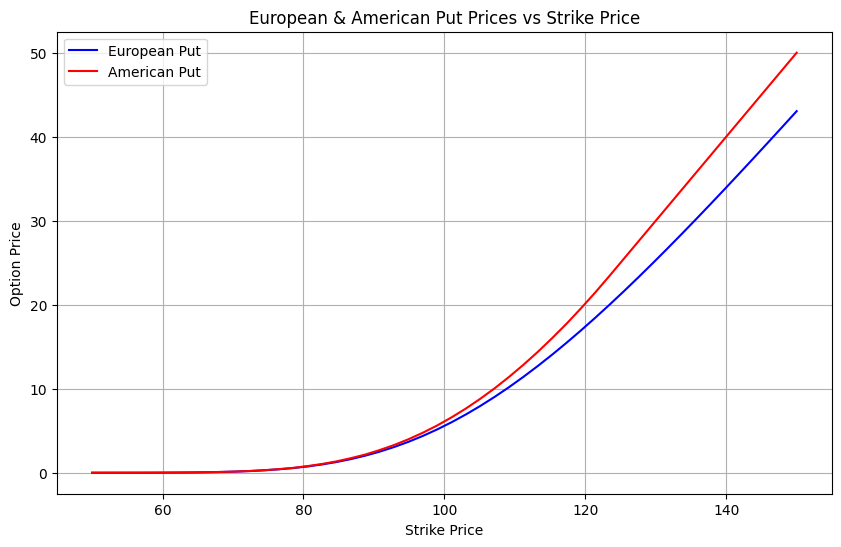

In [ ]:
european_puts_K = [black_scholes_put(100, K, T, r, sigma) for K in K_range]
american_puts_K = [binomial_tree_american(100, K, T, r, sigma, 'put') for K in K_range]

plt.figure(figsize=(10, 6))
plt.plot(K_range, european_puts_K, label='European Put', color='blue')
plt.plot(K_range, american_puts_K, label='American Put', color='red')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('European & American Put Prices vs Strike Price')
plt.legend()
plt.grid()
plt.show()

23.For the 5 strikes that your group member computed in Q15 and Q16, check
whether put-call parity holds (within sensible rounding). Briefly comment on t
reasons why/why not this is the case.

In [ ]:
import numpy as np

def check_put_call_parity(S0, r, T, strikes, call_prices, put_prices):
    for i, K in enumerate(strikes):
        lhs = call_prices[i] - put_prices[i]  # C - P
        rhs = S0 - K * np.exp(-r * T)  # S0 - K * exp(-rT)

        print(f"Strike: {K:.2f}")
        print(f"C - P: {lhs:.4f}")
        print(f"S0 - K * exp(-rT): {rhs:.4f}")
        print(f"Difference: {abs(lhs - rhs):.6f}")
        print("Put-Call Parity Holds?", np.isclose(lhs, rhs, atol=1e-4))
        print("-" * 40)

# Given input values
S0 = 100  # Initial stock price
r = 0.05  # Risk-free rate
T = 0.25  # Time to maturity

# Moneyness levels and corresponding strikes
moneyness = {"Deep_OTM": 0.9, "OTM": 0.95, "ATM": 1.0, "ITM": 1.05, "Deep_ITM": 1.1}
strikes = [S0 * v for v in moneyness.values()]

# Call and Put prices
call_prices = [11.670245485966632, 7.714735505928879, 4.614497978118606, 2.4776753018054336, 1.1912461198265352]
put_prices = [0.5522475304160466, 1.5346265528476954, 3.3722780275068414, 6.173344353663073, 9.82480417415361]

# Check put-call parity
check_put_call_parity(S0, r, T, strikes, call_prices, put_prices)

Strike: 90.00
C - P: 11.1180
S0 - K * exp(-rT): 11.1180
Difference: 0.000000
Put-Call Parity Holds? True
----------------------------------------
Strike: 95.00
C - P: 6.1801
S0 - K * exp(-rT): 6.1801
Difference: 0.000000
Put-Call Parity Holds? True
----------------------------------------
Strike: 100.00
C - P: 1.2422
S0 - K * exp(-rT): 1.2422
Difference: 0.000000
Put-Call Parity Holds? True
----------------------------------------
Strike: 105.00
C - P: -3.6957
S0 - K * exp(-rT): -3.6957
Difference: 0.000000
Put-Call Parity Holds? True
----------------------------------------
Strike: 110.00
C - P: -8.6336
S0 - K * exp(-rT): -8.6336
Difference: 0.000000
Put-Call Parity Holds? True
----------------------------------------


###Reasons
1. Efficient market assumption: the assumption made in the calculation is that the market is arbitrage free. Therefore there are no riskless opportunities.
2. No Divindend Impact: Here, the stock is assumed not to pay any divindends during the life of the option.  

 **24**.  For the 5 strikes that your group member computed in Q17 and Q18, check
whether put-call parity holds (within sensible rounding). Briefly comment on t
reasons why/why not this is the case.

In [ ]:
import numpy as np

class TrinomialAmericanModel:
    def __init__(self, S0, r, sigma, mat, K):
        self.S0 = S0
        self.r = r
        self.sigma = sigma
        self.T = mat
        self.K = K

    def __compute_probs(self):
        self.pu = ((np.exp(self.r * self.h / 2) - np.exp(-self.sigma * np.sqrt(self.h / 2))) /
                   (np.exp(self.sigma * np.sqrt(self.h / 2)) - np.exp(-self.sigma * np.sqrt(self.h / 2)))) ** 2
        self.pd = ((-np.exp(self.r * self.h / 2) + np.exp(self.sigma * np.sqrt(self.h / 2))) /
                   (np.exp(self.sigma * np.sqrt(self.h / 2)) - np.exp(-self.sigma * np.sqrt(self.h / 2)))) ** 2
        self.pm = 1 - self.pu - self.pd

    def __check_up_value(self):
        self.u = np.exp(self.sigma * np.sqrt(2 * self.h))
        self.d = 1 / self.u

    def __gen_stock_vec(self, nb):
        vec_u = self.u * np.ones(nb)
        np.cumprod(vec_u, out=vec_u)

        vec_d = self.d * np.ones(nb)
        np.cumprod(vec_d, out=vec_d)

        res = np.concatenate((vec_d[::-1], [1.0], vec_u))
        return res * self.S0

    def compute_current_price(self, crt_vec_stock, nxt_vec_prices, is_call=True):
        expectation = np.zeros(crt_vec_stock.size)
        for i in range(expectation.size):
            expectation[i] = (nxt_vec_prices[i] * self.pd +
                              nxt_vec_prices[i + 1] * self.pm +
                              nxt_vec_prices[i + 2] * self.pu) * self.discount
            # Early exercise condition
            if is_call:
                expectation[i] = max(expectation[i], max(crt_vec_stock[i] - self.K, 0))
            else:
                expectation[i] = max(expectation[i], max(self.K - crt_vec_stock[i], 0))
        return expectation

    def price(self, nb_steps, is_call=True):
        self.h = self.T / nb_steps
        self.__check_up_value()
        self.__compute_probs()
        self.discount = np.exp(-self.r * self.h)

        final_vec_stock = self.__gen_stock_vec(nb_steps)
        final_payoff = np.maximum(final_vec_stock - self.K, 0) if is_call else np.maximum(self.K - final_vec_stock, 0)
        nxt_vec_prices = final_payoff

        for i in range(1, nb_steps + 1):
            vec_stock = self.__gen_stock_vec(nb_steps - i)
            nxt_vec_prices = self.compute_current_price(vec_stock, nxt_vec_prices, is_call)

        return nxt_vec_prices[0]


# **American Call & Put Pricing**
moneyness = {"Deep_OTM": 0.9, "OTM": 0.95, "ATM": 1.0, "ITM": 1.05, "Deep_ITM": 1.1}

print("American Call Prices:")
for k, v in moneyness.items():
    am_call = TrinomialAmericanModel(S0=100, r=0.05, sigma=0.2, mat=0.25, K=100 * v)
    print(f"{k}: {am_call.price(1000, is_call=True)}")

print("\nAmerican Put Prices:")
for k, v in moneyness.items():
    am_put = TrinomialAmericanModel(S0=100, r=0.05, sigma=0.2, mat=0.25, K=100 * v)
    print(f"{k}: {am_put.price(1000, is_call=False)}")

American Call Prices:
Deep_OTM: 11.670245485966632
OTM: 7.714735505928879
ATM: 4.614497978118606
ITM: 2.4776753018054336
Deep_ITM: 1.1912461198265352

American Put Prices:
Deep_OTM: 0.5631052751092721
OTM: 1.5728381898742083
ATM: 3.4795037332972645
ITM: 6.423390580723973
Deep_ITM: 10.33054771625936


In [ ]:
import numpy as np

def check_put_call_parity_american(S0, r, T, strikes, call_prices, put_prices):
    for i, K in enumerate(strikes):
        lhs = call_prices[i] - put_prices[i]  # C - P
        rhs = S0 - K * np.exp(-r * T)  # S0 - K * exp(-rT)

        print(f"Strike: {K:.2f}")
        print(f"C - P: {lhs:.6f}")
        print(f"S0 - K * exp(-rT): {rhs:.6f}")
        print(f"Difference: {abs(lhs - rhs):.6f}")
        print("Put-Call Parity Holds?", np.isclose(lhs, rhs, atol=1e-4))
        print("-" * 40)

# Given input values for American options
S0 = 100  # Initial stock price
r = 0.05  # Risk-free rate
T = 0.25  # Time to maturity

# Moneyness levels and corresponding strikes
moneyness = {"Deep_OTM": 0.9, "OTM": 0.95, "ATM": 1.0, "ITM": 1.05, "Deep_ITM": 1.1}
strikes = [S0 * v for v in moneyness.values()]

# True American Call and Put Prices
am_call_prices = [11.670245485966632, 7.714735505928879, 4.614497978118606, 2.4776753018054336, 1.1912461198265352]
am_put_prices = [0.5631052751092721, 1.5728381898742083, 3.4795037332972645, 6.423390580723973, 10.33054771625936]

# Check put-call parity for American options
check_put_call_parity_american(S0, r, T, strikes, am_call_prices, am_put_prices)

Strike: 90.00
C - P: 11.107140
S0 - K * exp(-rT): 11.117998
Difference: 0.010858
Put-Call Parity Holds? False
----------------------------------------
Strike: 95.00
C - P: 6.141897
S0 - K * exp(-rT): 6.180109
Difference: 0.038212
Put-Call Parity Holds? False
----------------------------------------
Strike: 100.00
C - P: 1.134994
S0 - K * exp(-rT): 1.242220
Difference: 0.107226
Put-Call Parity Holds? False
----------------------------------------
Strike: 105.00
C - P: -3.945715
S0 - K * exp(-rT): -3.695669
Difference: 0.250046
Put-Call Parity Holds? False
----------------------------------------
Strike: 110.00
C - P: -9.139302
S0 - K * exp(-rT): -8.633558
Difference: 0.505744
Put-Call Parity Holds? False
----------------------------------------


For the american option, put call parity does not hold. This is because it allows for an early exercise.

When an erly exercise is allowed, it affects pricing making it not to hold






# **Step 3**   

We now use real–world data:

    S0=180
    r=2%  
    σ=25%
    T=0.5 years,
    K=182


 *European Put Delta Hedging with a 3–Step Binomial Tree*




##### **(25a) - Price the European Put**

In [ ]:
S0_hedge = 180
r_hedge = 0.02
sigma_hedge = 0.25
T_hedge = 0.5
K_hedge = 182
N_hedge = 3

european_put_price_hedge = binomial_tree_european(S0_hedge, K_hedge, T_hedge, r_hedge, sigma_hedge, N_hedge, option_type='put')
print("European Put Price (3-step Binomial):", european_put_price_hedge)


European Put Price (3-step Binomial): 13.82238509505968


This value is the risk-neutral present value of the expected option payoff, the result of combined effect of volatility, time, and the risk-free rate. The 3-step tree provides a crude approximation of the option value.

**(25b) – Delta Hedging Along One Chosen Path**

For a 3–step tree, we build the full tree so that we can compute deltas at each node.

In [ ]:
def binomial_tree_details(S0, K, T, r, sigma, N, option_type='put'):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r*dt) - d) / (u - d)

    asset_tree = np.zeros((N+1, N+1))
    option_tree = np.zeros((N+1, N+1))

    # Fill asset tree:
    for i in range(N+1):
        for j in range(i+1):
            asset_tree[i, j] = S0 * (u**(i-j)) * (d**j)

    # Terminal payoffs:
    for j in range(N+1):
        if option_type == 'put':
            option_tree[N, j] = max(K - asset_tree[N, j], 0)
        else:
            option_tree[N, j] = max(asset_tree[N, j] - K, 0)

    # Backward induction:
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            option_tree[i, j] = np.exp(-r*dt) * (p * option_tree[i+1, j] + (1-p) * option_tree[i+1, j+1])

    return asset_tree, option_tree, u, d, p, dt

asset_tree, option_tree, u, d, p, dt = binomial_tree_details(S0_hedge, K_hedge, T_hedge, r_hedge, sigma_hedge, N_hedge, option_type='put')
print("Asset Tree:\n", asset_tree)
print("Option Tree:\n", option_tree)


Asset Tree:
 [[180.           0.           0.           0.        ]
 [199.34139817 162.53523      0.           0.        ]
 [220.76107236 180.         146.76500551   0.        ]
 [244.48233791 199.34139817 162.53523    132.5249107 ]]
Option Tree:
 [[13.8223851   0.          0.          0.        ]
 [ 5.01268419 22.4055917   0.          0.        ]
 [ 0.          9.87779048 34.62933781  0.        ]
 [ 0.          0.         19.46477    49.4750893 ]]


The asset tree shows how the underlying stock price evolves over three time steps. Starting at 180, the tree branches to show possible prices after one step (approximately 199.34 and 162.54), and further possible outcomes at later steps, corresponding to up and down movements in the stock.

The option tree is built using backward induction. The final row gives the intrinsic values at expiry (computed as max⁡(K−S,0)max(K−S,0) for a put). Moving backwards, the tree calculates discounted expected option values at all prior nodes, finally obtaining the first node value 13.82, the same as the earlier computed European put price.

Next, we choose a path. For example, we select the path:

    Step 1: Up (node (1,0))
    Step 2: Down (node (2,1))
    Step 3: Up (node (3,1))

We compute the delta at each node as:
Δi,j=V(i+1,j)−V(i+1,j+1)/[S(i+1,j)−S(i+1,j+1)]
​

In [ ]:
def compute_delta(option_tree, asset_tree, i, j):
    V_up = option_tree[i+1, j]
    V_down = option_tree[i+1, j+1]
    S_up = asset_tree[i+1, j]
    S_down = asset_tree[i+1, j+1]
    return (V_up - V_down) / (S_up - S_down)

# Chosen path nodes:
path = [(0,0), (1,0), (2,1), (3,1)]
hedge_table = []
for (i,j) in path[:-1]:
    delta = compute_delta(option_tree, asset_tree, i, j)
    hedge_table.append((i, asset_tree[i,j], option_tree[i,j], delta))

print("Delta Hedging Table (European Put, 3-step):")
print("Step | Stock Price | Option Value | Delta")
for row in hedge_table:
    print(row)


Delta Hedging Table (European Put, 3-step):
Step | Stock Price | Option Value | Delta
(0, 180.0, 13.82238509505968, -0.47255414985796884)
(1, 199.3413981690584, 5.012684189184799, -0.2423339208720217)
(2, 180.0, 9.877790482863336, -0.5288453258819983)


Now, we simulate the cash account evolution. We Suppose that at time 0 we receive the option premium and then set up a hedge by buying Δ shares. When delta changes we adjust our position (and cash account).

In [ ]:
portfolio_value = option_tree[0,0]
position = hedge_table[0][3]  # initial delta
cash_account = portfolio_value - position * asset_tree[0,0]

hedge_simulation = []
hedge_simulation.append((0, asset_tree[0,0], position, cash_account))

for idx in range(1, len(path)):
    i, j = path[idx]
    S = asset_tree[i, j]
    if i < N_hedge:
        delta_new = compute_delta(option_tree, asset_tree, i, j)
    else:
        delta_new = 0
    position_change = delta_new - position
    cash_account -= position_change * S
    position = delta_new
    hedge_simulation.append((i, S, position, cash_account))

print("Hedging Simulation (European Put, 3-step):")
print("Step | Stock Price | Hedge Delta | Cash Account")
for row in hedge_simulation:
    print(row)


Hedging Simulation (European Put, 3-step):
Step | Stock Price | Hedge Delta | Cash Account
(0, 180.0, -0.47255414985796884, 98.88213206949408)
(1, 199.3413981690584, -0.2423339208720217, 52.98970973663459)
(2, 180.0, -0.5288453258819983, 104.56176263843037)
(3, 199.34139816905844, 0, -0.8590040380585151)


Step-by-step simulation is carried out wherein asset and option price trees are constructed, deltas at each node are computed, and a delta hedging strategy is simulated on a chosen path. The resultant table shows the evolution of the hedge position and cash account over the tree steps. This real-world example demonstrates how dynamic hedging adjustments are made to hedge risk in a European put.

**26. American Put Delta Hedging with a 25–Step Tree**



First, we build a tree for an American put (including early exercise):

In [ ]:
def binomial_tree_details_american(S0, K, T, r, sigma, N, option_type='put'):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r*dt) - d) / (u - d)

    asset_tree = np.zeros((N+1, N+1))
    option_tree = np.zeros((N+1, N+1))

    for i in range(N+1):
        for j in range(i+1):
            asset_tree[i, j] = S0 * (u**(i-j)) * (d**j)

    for j in range(N+1):
        if option_type == 'put':
            option_tree[N, j] = max(K - asset_tree[N, j], 0)
        else:
            option_tree[N, j] = max(asset_tree[N, j] - K, 0)

    for i in range(N-1, -1, -1):
        for j in range(i+1):
            continuation = np.exp(-r*dt) * (p * option_tree[i+1, j] + (1-p) * option_tree[i+1, j+1])
            exercise = max(K - asset_tree[i,j], 0) if option_type=='put' else max(asset_tree[i,j]-K,0)
            option_tree[i, j] = max(continuation, exercise)

    return asset_tree, option_tree, u, d, p, dt

N_american = 25
asset_tree_am, option_tree_am, u_am, d_am, p_am, dt_am = binomial_tree_details_american(S0_hedge, K_hedge, T_hedge, r_hedge, sigma_hedge, N_american, option_type='put')
american_put_price = option_tree_am[0,0]
print("American Put Price (25-step Binomial):", american_put_price)


American Put Price (25-step Binomial): 13.03571894719869


Now, we simulate a delta hedging strategy along one chosen path. For illustration we choose the “all–up” path (i.e. at each step, j = 0):

In [ ]:
def compute_delta_american(option_tree, asset_tree, i, j):
    V_up = option_tree[i+1, j]
    V_down = option_tree[i+1, j+1]
    S_up = asset_tree[i+1, j]
    S_down = asset_tree[i+1, j+1]
    return (V_up - V_down) / (S_up - S_down)

# Choose the all–up path:
path_am = [(i, 0) for i in range(N_american+1)]
hedge_simulation_am = []
position = compute_delta_american(option_tree_am, asset_tree_am, 0, 0)
cash_account = option_tree_am[0,0] - position * asset_tree_am[0,0]
hedge_simulation_am.append((0, asset_tree_am[0,0], position, cash_account))

for i in range(0, N_american):
    j = 0  # along the all-up branch
    if i < N_american:
        delta_new = compute_delta_american(option_tree_am, asset_tree_am, i, j)
    else:
        delta_new = 0
    S = asset_tree_am[i+1, j]
    position_change = delta_new - position
    cash_account -= position_change * S
    position = delta_new
    hedge_simulation_am.append((i+1, S, position, cash_account))

print("American Put Delta Hedging Simulation (All–Up Path):")
print("Step | Stock Price | Hedge Delta | Cash Account")
for row in hedge_simulation_am:
    print(row)


American Put Delta Hedging Simulation (All–Up Path):
Step | Stock Price | Hedge Delta | Cash Account
(0, 180.0, -0.47555673200225407, 98.63593070760442)
(1, 186.47779865799848, -0.47555673200225407, 98.63593070760442)
(2, 193.18871884629456, -0.3951103312297642, 83.09459360657154)
(3, 200.14115008897775, -0.3162975702032648, 67.32091697304018)
(4, 207.34378383040357, -0.24227190055199455, 51.972154526966335)
(5, 214.8056243006309, -0.17603917282279016, 37.74499209796088)
(6, 222.53599977188176, -0.12004652013981199, 25.284611153274597)
(7, 230.54457422009645, -0.07577515283699376, 15.07808762830487)
(8, 238.84135940616187, -0.04346573085226835, 7.361261359845718)
(9, 247.43672739191612, -0.022084306441002406, 2.0707116765444473)
(10, 256.34142350657663, -0.009569503544761751, -1.1373507127821103)
(11, 265.56657977980063, -0.003326719916245764, -2.795225409312435)
(12, 275.12372885817194, -0.0008280459623115816, -3.4826699047195993)
(13, 285.02481842251086, -0.00011119974517686524, -3.6

 Using a finer 25-step binomial tree, We performs delta hedging for an American put on an all–up situation. The simulation computes delta at every step and rebalances the hedge, and keeps track of changes to the cash account. The results highlight the added complexity and hedging adjustments in situations where early exercise is allowed.

**27. Asian ATM Put Option**


Pricing Asian options (whose payoff depends on the average price) requires a different lattice or Monte Carlo method. Below is a simple Monte Carlo pricing function for an Asian put and a brief comment on hedging.

In [ ]:
def asian_option_mc(S0, K, T, r, sigma, n_steps, n_sim, option_type='put'):
    dt = T / n_steps
    payoffs = []
    for i in range(n_sim):
        S_path = [S0]
        for t in range(n_steps):
            S_path.append(S_path[-1] * np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal()))
        avg_price = np.mean(S_path)
        if option_type == 'put':
            payoff = max(K - avg_price, 0)
        elif option_type == 'call':
            payoff = max(avg_price - K, 0)
        payoffs.append(np.exp(-r*T) * payoff)
    return np.mean(payoffs)

K_asian = S0_hedge  # ATM
asian_put_price = asian_option_mc(S0_hedge, K_asian, T_hedge, r_hedge, sigma_hedge, 25, 10000, option_type='put')
print("Asian ATM Put Price (MC):", asian_put_price)


Asian ATM Put Price (MC): 6.764179842224986


A Monte Carlo simulation is used to value an Asian ATM put option, with the payoff being a function of the stock's average price over time. The price computed is the discounted expected payoff of the path-dependent option. This cell shows a second approach to the pricing of options with non-standard, path-dependent features and shows that the averaging effect tends to smooth out sensitivities.

**References**

1. **Cox, Ross & Rubinstein (1979):**  
   - *Cox, J. C., Ross, S. A., & Rubinstein, M. (1979). Option pricing: A simplified approach. Journal of Financial Economics, 7(3), 229–263.*  
     This is the seminal paper introducing the binomial option pricing model.

2. **Hull, J. C. (2018):**  
   - *Hull, J. C. (2018). Options, Futures, and Other Derivatives (10th ed.). Pearson.*  
     A comprehensive text covering option pricing models, Greeks, and risk management, including both binomial and trinomial trees.

3. **Wilmott, P. (2006):**  
   - *Wilmott, P. (2006). Paul Wilmott on Quantitative Finance (2nd ed.). Wiley.*  
     This book provides practical insights and advanced techniques used in quantitative finance, including lattice models and hedging.

4. **Broadie & Glasserman (1997):**  
   - *Broadie, M., & Glasserman, P. (1997). Monte Carlo methods and option pricing. Mathematical Finance, 7(1), 35–52.*  
     An excellent reference for Monte Carlo methods in option pricing, especially useful for pricing Asian options.

5. **Hull, J. C. (2021):**
   - *Options futures and other derivatives*. 11th Edition. Pearson. Chapter 11.
